# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

THis particular notebook will use the [SIDES simulation](http://cesam.lam.fr/sides/) from [Bethermin et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...607A..89B/abstract) to test how well the XID+SED CIGALE model recovers the true parameters

In [1]:

field=['Lockman-SWIRE']
path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
#path_to_SPIRE=['/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/']
redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]
#redshift_file=["/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]

Import required modules

In [2]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
try:
    source=[np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[0]

Set image and catalogue filenames

In [4]:
#Folder containing maps
pswfits=path_to_SPIRE[0]+'{}_SPIRE250_v1.0.fits'.format(field[0])#SPIRE 250 map
pmwfits=path_to_SPIRE[0]+'{}_SPIRE350_v1.0.fits'.format(field[0])#SPIRE 350 map
plwfits=path_to_SPIRE[0]+'{}_SPIRE500_v1.0.fits'.format(field[0])#SPIRE 500 map




#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [5]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[3].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[3].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[3].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module [pymoc](http://pymoc.readthedocs.io/en/latest/) to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution)

Read in the SIDES catalogue

In [208]:
from astropy.io import fits
Mock=fits.open('../../../data/Mock_cat_Bethermin2017.fits',format='fits')


In [209]:
import pandas as pd
cols=['REDSHIFT','RA','DEC','SFR','SMIPS24','SSPIRE250','SSPIRE350','SSPIRE500']
Mock=pd.DataFrame(np.vstack([Mock[1].data[c].reshape(-1) for c in cols]).T,columns=cols)
Mock=Mock[Mock['SMIPS24']>5E-6]

Things to do:
   * create a fits image with same coords as Mock cat 
   * Select a source from Mock cat
   * create model map from it using pointing matrix
   * Fit model map with emulator
   * compare fluxes, parameters and hierarchical parameters
   
Repeat for multiple cutouts


In [210]:
[np.nanmedian(m) for p, m in  zip([pixsize250,pixsize350,pixsize500],[nim250,nim350,nim500])]
    

[3.196482237345278, 3.0866089540719104, 3.681391134859725]

## Create empty maps

In [211]:
maps=[fits.HDUList([fits.PrimaryHDU(np.zeros((np.ceil(1.5/(p/3600.0)).astype(int),np.ceil(1.5/(p/3600.0)).astype(int)))),
                    fits.PrimaryHDU(np.ones((np.ceil(1.5/(p/3600.0)).astype(int),np.ceil(1.5/(p/3600.0)).astype(int)))*np.nanmedian(m))]) for p,m in zip([pixsize250,pixsize350,pixsize500],[nim250,nim350,nim500])]

In [212]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
for i,h in enumerate([w_250,w_350,w_500]):
    for e in range(0,2):
        ra_obj=0.75
        dec_obj=0.75
        w = wcs.WCS(naxis=2)

        # reference pixel coordinate
        w.wcs.crpix = [int(maps[i][e].data.shape[0]/2),int(maps[i][e].data.shape[1]/2)]

        # sizes of the pixel in degrees
        w.wcs.cdelt = [h.wcs.cd[0,0],h.wcs.cd[1,1]]

        # converting ra and dec into degrees
        c = SkyCoord(ra_obj*u.degree, dec_obj*u.degree)
        w.wcs.crval = [c.ra.deg, c.dec.deg]

        # the units of the axes are in degrees
        #w.wcs.cunit = ['deg', 'deg']
        w.wcs.ctype=['RA---TAN','DEC--TAN']
        wcs_header = w.to_header()


        maps[i][e].header.update(wcs_header)


In [213]:
np.random.seed(1)
rand=np.random.random_integers(0,len(Mock))

c = SkyCoord(ra=Mock['RA'][rand]*u.degree, dec=Mock['DEC'][rand]*u.degree)

import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,100,15)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 227077 + 1) instead
  


XID+ is built around two python classes. A prior and posterior class. There should be a prior class for each map being fitted. It is initiated with a map, noise map, primary header and map header and can be set with a MOC. It also requires an input prior catalogue and point spread function.


In [214]:
#---prior250--------
prior250=xidplus.prior(maps[0][0].data,maps[0][1].data,None,maps[0][0].header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(Mock['RA'],Mock['DEC'],'photoz',ID=Mock.index)
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(maps[1][0].data,maps[1][1].data,None,maps[1][0].header, moc=moc)
prior350.prior_cat(Mock['RA'],Mock['DEC'],'photoz',ID=Mock.index)
prior350.prior_bkg(-5.0,5)
#---prior500--------
prior500=xidplus.prior(maps[2][0].data,maps[2][1].data,None,maps[2][0].header, moc=moc)
prior500.prior_cat(Mock['RA'],Mock['DEC'],'photoz',ID=Mock.index)
prior500.prior_bkg(-5.0,5)

Set PSF. For SPIRE, the PSF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively. Lets use the astropy module to construct a Gaussian PSF and assign it to the three XID+ prior classes.

In [215]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [216]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')
print('source density = {}'.format(prior250.nsrc/moc.area_sq_deg))

fitting 265 sources 

using 872, 457 and 219 pixels
source density = 109194.9755600244


Before fitting, the prior classes need to take the PSF and calculate how muich each source contributes to each pixel. This process provides what we call a pointing matrix. Lets calculate the pointing matrix for each prior class

In [217]:
#prior24.get_pointing_matrix()
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


In [218]:
bkg=[-5,-6,-7]
prior250.sim=xidplus.posterior_maps.ymod_map(prior250,Mock['SSPIRE250'][prior250.ID]*1000.0).reshape(-1)+bkg[0]+np.random.normal(scale=prior250.snim)
prior350.sim=xidplus.posterior_maps.ymod_map(prior350,Mock['SSPIRE350'][prior250.ID]*1000.0).reshape(-1)+bkg[1]+np.random.normal(scale=prior350.snim)
prior500.sim=xidplus.posterior_maps.ymod_map(prior500,Mock['SSPIRE500'][prior250.ID]*1000.0).reshape(-1)+bkg[2]+np.random.normal(scale=prior500.snim)

([<aplpy.core.FITSFigure at 0x7fac011731d0>,
 <Figure size 2160x720 with 6 Axes>)

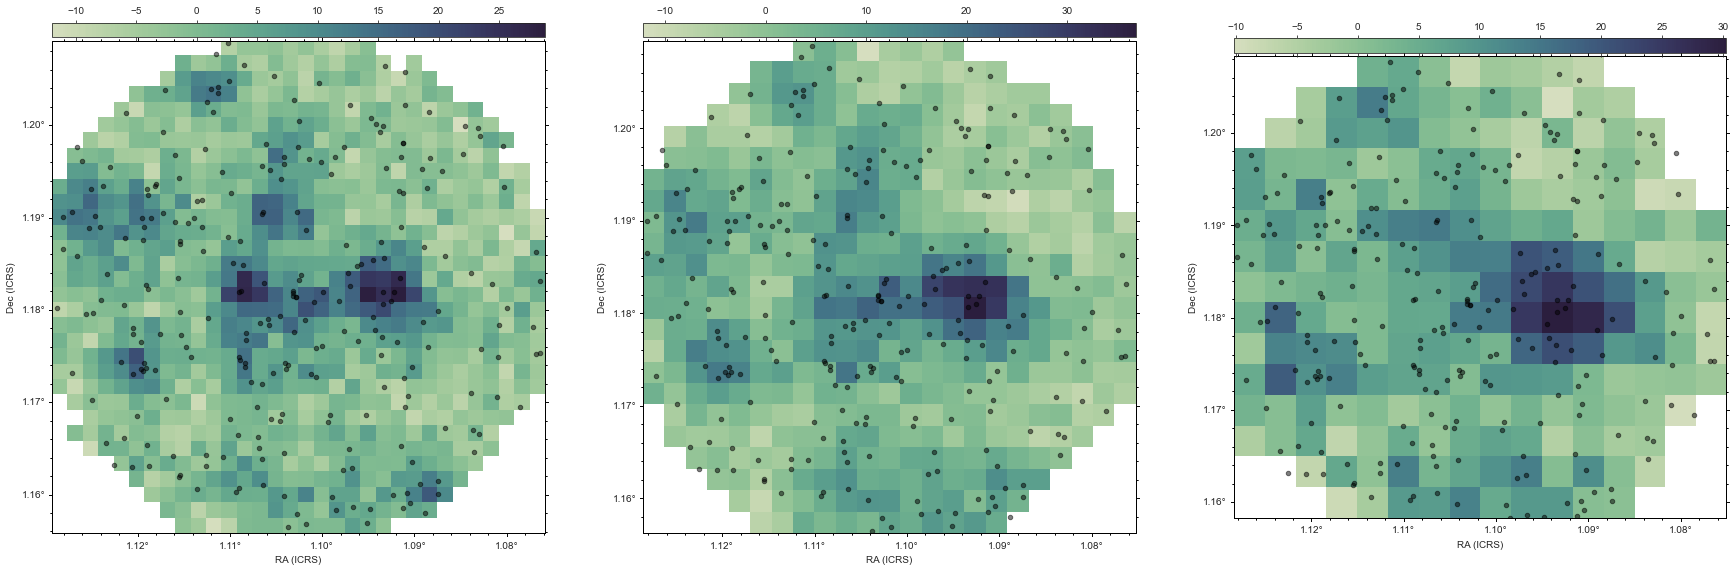

In [219]:
xidplus.plot_map([prior250,prior350,prior500])

In [220]:
xidplus.save([prior250,prior350,prior500],None,'SIDES_Sim_test')

In [238]:
Mock.loc[prior250.ID.values].to_csv('prior_list_SIDES_sim_test.csv')